## Cellular Network Simulation

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import os
import logging
import simpy
import pandas as pd
import random
import re
import numpy as np
import pickle
from joblib import load
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
pd.set_option('future.no_silent_downcasting', True)

## Data Paths

The data paths are set up for the simulation files, as part of the simulation the models created in the [models](../models/models.ipynb) are used within the simulation. The folders within the simulation for saving the results are also created.
- [SMS Spam Datasets](./simulation/data) contains the SMS Spam datasets used in the simulation.
- [Simulation Results](./simulation/results) contains the results of the simulation.
- [Simulation Logs](./simulation/logs) contains the logs of the simulation.

In [2]:
simulation_dir = '../'
model_dir = './models'
data_dir = './data'
results_dir = './results'
log_dir = './logs'

# Get the absolute path for model_dir
abs_model_dir = os.path.abspath(os.path.join(simulation_dir, model_dir))

cv_path = os.path.abspath(os.path.join(simulation_dir, model_dir, 'count_vectorizer.pkl'))
with open(cv_path, 'rb') as file:
    cv = pickle.load(file)

## Network Logging

The key feature of the simulation is the logging of the network. The network is logged at each time step, the logs are saved in the [Simulation Logs](./simulation/logs) folder. The logs are saved in the format of a CSV file.
- The regular logs contain the following information:
    - Time: The time step of the simulation.
    - Log Level: The level of the log.
    - Log Message: The message of the log.
    - SMS Content: The content of the SMS.
- The Alert Level logs contain the following information:
    - Time: The time step of the simulation.
    - Alert Level: The level of the alert.
    - Alert Message: The message of the alert.
    - Baseband Unit: The location of the baseband unit that generated the alert.
    - Spam Volume: The volume of spam messages detected.

In [3]:
class SimulationTimeFilter(logging.Filter):
    def __init__(self, env):
        super().__init__()
        self.env = env

    def filter(self, record):
        hours, remainder = divmod(self.env.now, 3600)
        minutes, seconds = divmod(remainder, 60)
        record.simulation_time = "{:02}:{:02}:{:05.2f}".format(
            int(hours), int(minutes), seconds)
        return True

# A function to set up logging for the simulation, one log is for regular messages and the other is for alerts
# Alerts are critical messages that require immediate attention
def setup_logging(env, normal_log_filename, alert_log_filename):
    # Set up file handlers for both normal and alert logs
    normal_handler = logging.FileHandler(
        os.path.join(log_dir, normal_log_filename), mode='a')
    alert_handler = logging.FileHandler(
        os.path.join(log_dir, alert_log_filename), mode='a')

    # Define CSV formatters with appropriate fields
    normal_fields = ['Simulation Time', 'Log Level', 'Message', 'SMS Content']
    normal_formatter = logging.Formatter(
        '%(simulation_time)s,%(levelname)s,%(message)s,%(sms_content)s')

    alert_fields = ['Simulation Time', 'Log Level',
        'Message', 'Baseband Unit', 'Spam Volume']
    alert_formatter = logging.Formatter(
        '%(simulation_time)s,%(levelname)s,%(message)s,%(baseband_unit)s,%(spam_volume)s')

    # Write headers to the log files if they are newly created
    if os.stat(os.path.join(log_dir, normal_log_filename)).st_size == 0:
        with open(os.path.join(log_dir, normal_log_filename), 'w') as f:
            csv.writer(f).writerow(normal_fields)
    if os.stat(os.path.join(log_dir, alert_log_filename)).st_size == 0:
        with open(os.path.join(log_dir, alert_log_filename), 'w') as f:
            csv.writer(f).writerow(alert_fields)

    # Attach formatters to the handlers
    normal_handler.setFormatter(normal_formatter)
    alert_handler.setFormatter(alert_formatter)

    # Set up the normal logger
    normal_logger = logging.getLogger('normal_logger')
    normal_logger.setLevel(logging.INFO)
    normal_logger.addHandler(normal_handler)
    normal_logger.propagate = False

    # Set up the alert logger
    alert_logger = logging.getLogger('alert_logger')
    alert_logger.setLevel(logging.CRITICAL)
    alert_logger.addHandler(alert_handler)
    alert_logger.propagate = False

    # Add simulation time filter to both loggers
    normal_logger.addFilter(SimulationTimeFilter(env))
    alert_logger.addFilter(SimulationTimeFilter(env))

    return normal_logger, alert_logger

## Data Preprocessing

- The load sms data function is similar to what was used within the model training. Here the count verctorizer created during model creation is used to transform the SMS data into a format that can be used within the simulation. The text data is transformed to be used within the simulation.
- The text data undergoes preprocessing, where various patterns such as email addresses, URLs, phone numbers, currency symbols, and digits are replaced with specific tokens ('emailaddr', 'httpaddr', 'phonenumbr', 'moneysymb', 'numbr'). Furthermore, non-alphanumeric characters are removed, and the text is converted to lowercase.

In [4]:
def load_sms_data(file_path):
    df = pd.read_csv(file_path, encoding='latin-1')
    df.rename(columns=lambda x: x.strip(), inplace=True)
    df = df[['target', 'text']]
    df['target'] = df['target'].replace({'ham': 0, 'spam': 1})

    # Preprocess text data
    def preprocess_text(text):
        text = re.sub(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', text)
        text = re.sub(
            r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr', text)
        text = re.sub(r'£|\$', 'moneysymb', text)
        text = re.sub(
            r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b', 'phonenumbr', text)
        text = re.sub(r'\d+(\.\d+)?', 'numbr', text)
        text = re.sub(r'[^\w\d\s]', ' ', text)
        text = text.lower()
        words = text.split()
        ps = PorterStemmer()
        words = [ps.stem(word) for word in words if word not in set(
            stopwords.words('english'))]
        return ' '.join(words)

    # Apply preprocessing to text column
    df['processed_text'] = df['text'].apply(preprocess_text)
    features = cv.transform(df['processed_text']).toarray()
    return list(zip(df['target'], features, df['text']))

## Network Device Classes

The network device classes are created to simulate the network devices within the cellular network.

**MobileDevice class:**
- Responsible for simulating the sending of SMS messages from mobile devices.
- The `send_sms` function orchestrates the transmission of SMS messages to the baseband unit at varying intervals.
- Logs each message sent, including details like the content and timing of the transmission.

**RadioUnit class:**
- Handles the reception of SMS messages from the mobile device.
- The `process` method simulates the delay and processing of the messages before forwarding them to the next unit.
- The `process` function also Logs the receipt and processing times of messages.

**BasebandUnit class:**
- Acts as the network's traffic cop, analysing SMS content to identify spam messages.
- The `dynamic_capacity` method adjusts the processing capacity of the unit based on the time of day.
- The `process` method processes the message and classifies it as spam or ham, based on the content.
- The `process` function also Logs the receipt and processing times of messages. It also logs the classification of the message as spam or ham.
- The `check_spam_ratio` method evaluates the spam ratio and issues alerts if spam activity is above a designated threshold.
- The `evaluate_model` method evaluates the performance of the spam classification model.

**CoreNetwork class:**
- Receives processed messages from the BasebandUnit and forwards them to the mobile device.
- The `process` method simulates the delay and processing of the messages before forwarding them to the mobile device.

**ToMobileDevice class:**
- Receives the processed message thats gone over the network.
- The `process` method checks if the prediction of whether the message was ham or spam is correct. It logs the message received and stores the predicted/actual results.

In [5]:
# The MobileDevice class is responsible for sending SMS messages
class MobileDevice:
    def __init__(self, env, messages, controller, message_count, logger):
        self.env = env
        self.messages = [(target, features, message_content, env.now) for target,
                          features, message_content in random.sample(messages, message_count)]
        self.controller = controller
        self.logger = logger

    # The messages are sent at different intervals based on the time of day
    def send_sms(self):
        for target, features, message_content, _ in self.messages:
            sent_time = self.env.now
            interval = random.uniform(0.01, 1.0)
            yield self.env.timeout(interval)
            self.logger.info(f"SENDING FROM DEVICE: A message has been sent from the device", extra={
                             'sms_content': message_content})
            selected_radio_unit = random.choice(self.controller.radio_units)
            yield self.env.process(selected_radio_unit.process(target, features, message_content, sent_time))

# The radiounit is responsible for processing messages it's received from the mobile device
# It then sends them to its specific baseband unit
class RadioUnit:
    def __init__(self, env, next_unit, logger):
        self.env = env
        self.next_unit = next_unit
        self.logger = logger

    # The process method simulates the time taken to process a message
    def process(self, target, features, message_content, sent_time):
        base_delay = 0.02
        random_delay = random.uniform(0.01, 0.1)
        total_delay = base_delay + random_delay
        yield self.env.timeout(total_delay)
        self.logger.info(f"RECEIVED AT RADIO UNIT: The message has been received at the radio unit, with a delay of: {total_delay:.2f}s:", extra={
                         'sms_content': message_content[:30]})
        yield self.env.process(self.next_unit.process(target, features, message_content, sent_time))

# The BasebandUnit acts as a logical operator, it detects the spam SMS messages
# It alerts the network controller when the spam ratio exceeds a certain threshold
# It also then processes the messages to continue being sent over the network
class BasebandUnit:
    def __init__(self, env, next_unit, model, identifier, normal_logger, alert_logger):
        self.env = env
        self.next_unit = next_unit
        self.model = model
        self.identifier = identifier
        self.resource = simpy.Resource(env, capacity=self.dynamic_capacity())
        self.radio_units = [RadioUnit(env, self, normal_logger) for _ in range(2)]
        self.normal_logger = normal_logger
        self.alert_logger = alert_logger
        self.predictions = []
        self.actuals = []
        self.message_count = 0
        self.spam_count = 0

    # The dynamic_capacity method is used to vary the capacity over each minute
    def dynamic_capacity(self):
        current_second = int(self.env.now % 60)
        if 0 <= current_second < 30:
            return 225
        else:
            return 130

    # The process method simulates the time taken to process a message
    # It also predicts whether the message is spam or ham using the machine learning model
    # It then logs the message processing and sends it to the next unit
    def process(self, target, features, message_content, sent_time):
        with self.resource.request() as req:
            yield req
            predicted = self.model.predict(features.reshape(1, -1))[0]
            self.predictions.append(predicted)
            self.actuals.append(target)
            is_spam = predicted == 1
            delay = random.uniform(0.001, 0.3)
            yield self.env.timeout(delay)
            self.message_count += 1
            if is_spam:
                self.spam_count += 1
            # Use the appropriate logger based on message classification
            if is_spam:
                self.normal_logger.warning(f"PROCESSED AT BASEBAND UNIT: SPAM SMS message was processed at the baseband unit {self.identifier}", extra={
                                           'sms_content': message_content[:30]})
            else:
                self.normal_logger.info(f"PROCESSED AT BASEBAND UNIT: HAM SMS message was processed at the baseband unit {self.identifier}", extra={
                                        'sms_content': message_content[:30]})
            yield self.env.process(self.next_unit.process(target, features, message_content, sent_time))
            if self.message_count % 100 == 0:
                self.check_spam_ratio()

    # This method checks the spam ratio and alerts the network controller if it exceeds a certain threshold
    def check_spam_ratio(self):
        if self.message_count > 0:
            spam_ratio = self.spam_count / self.message_count
            if spam_ratio > 0.2:
                self.alert_logger.critical(f"CRITICAL ALERT: High spam volume detected at {self.identifier} and critical action is needed", extra={
                                           'baseband_unit': self.identifier, 'spam_volume': f"{spam_ratio:.2f}"})
            self.message_count = 0
            self.spam_count = 0

    # The evaluate_model method evaluates the performance of the model
    def evaluate_model(self):
        accuracy = accuracy_score(self.actuals, self.predictions)
        conf_matrix = confusion_matrix(self.actuals, self.predictions)
        class_report = classification_report(
            self.actuals, self.predictions, target_names=['Ham', 'Spam'])
        evaluation_text = f"{self.identifier} - Accuracy: {accuracy:.2f}\nConfusion Matrix:\n{conf_matrix}\nClassification Report:\n{class_report}\n"
        print(evaluation_text)
        return evaluation_text

# The core network acts as the base for the network, it receives the messages from the baseband unit
# It then processes the messages to be sent to the mobile device
class CoreNetwork:
    def __init__(self, env, next_unit):
        self.env = env
        self.next_unit = next_unit
        self.model = model

    # The process method simulates the time taken to process a message
    def process(self, target, processed_text, message_content, sent_time):
        yield self.env.timeout(1)
        classification = 'Spam' if self.model.predict([processed_text])[
                                                      0] == 1 else 'Ham'
        yield self.env.process(self.next_unit.process(target, message_content, classification, sent_time))

# The ToMobileDevice is the device that receives the messages from the core network
# It then processes the messages and logs the results
class ToMobileDevice:
    def __init__(self, env, logger=None):
        self.env = env
        self.results = []
        self.predictions = []
        self.actuals = []
        self.logger = logger  # Accept and store the logger

    # The process method simulates the time taken to process a message
    def process(self, target, message_content, classification, sent_time):
        # Simulate processing time at the mobile device
        yield self.env.timeout(1)
        latency = self.env.now - sent_time
        predicted = 1 if classification == 'Spam' else 0
        correct = (target == predicted)
        correctness = 'correctly' if correct else 'incorrectly'
        spam_label = predicted
        if self.logger:
            self.logger.info(f'MESSAGE RECEIVED ON MOBILE: A message has been received at the device with the latency of {latency:.2f}s', extra={
                             'sms_content': message_content[:30]})
        self.predictions.append(predicted)
        self.actuals.append(target)

**NetworkController class:**
- Manages the overall simulation environment and orchestrates the interactions between different network components.
- The `NetworkController` enumerates over a set amount of baseband units that are later defined. Each `BasebandUnit` is created and added to the network with it's own 2 `RadioUnit` units.
- The `evaluate_all_basebands` method evaluates the performance of the ML model in each BasebandUnit in the network.
- The `save_evaluation_results` method saves the evaluation results to a CSV file.

In [6]:
# The NetworkController class is responsible for setting up the network components and running the simulation
# It creates the baseband units, radio units, and mobile devices as well as links them together
# It sets up the different baseband units and gives each a unique identifier
class NetworkController:
    def __init__(self, env, datasets, normal_logger, alert_logger):
        self.env = env
        self.datasets = datasets
        self.basebands = []
        self.evaluation_results = []
        self.to_mobile_device = ToMobileDevice(
            env, logger=normal_logger)  # Pass the logger

        # Create the baseband units and radio units
        for i, data in enumerate(self.datasets):
            identifier = f"Baseband_{i+1}"
            core_network = CoreNetwork(env, self.to_mobile_device)
            baseband = BasebandUnit(
                env, core_network, model, identifier, normal_logger, alert_logger)
            radio_unit1 = RadioUnit(env, baseband, normal_logger)
            radio_unit2 = RadioUnit(env, baseband, normal_logger)
            baseband.radio_units = [radio_unit1, radio_unit2]
            self.basebands.append((baseband, data))

    def evaluate_all_basebands(self):
        total_predictions = []
        total_actuals = []
        for baseband, data in self.basebands:
            evaluation_result = baseband.evaluate_model()
            self.evaluation_results.append(evaluation_result)
            total_predictions.extend(baseband.predictions)
            total_actuals.extend(baseband.actuals)

        # Display and plot overall performance
        total_conf_matrix = self.display_test_results(total_actuals, total_predictions)
        self.plot_confusion_matrix(total_conf_matrix)

        return self.evaluation_results

    def display_test_results(self, y_test, y_pred):
        accuracy = accuracy_score(y_test, y_pred)
        cf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, target_names=['Ham', 'Spam'])

        print(f"Test set accuracy: {accuracy:.2f}")
        print("Confusion Matrix:\n", cf_matrix)
        print("Classification Report:\n", class_report)

        return cf_matrix

    def plot_confusion_matrix(self, cf_matrix, title='Confusion Matrix with Detailed Annotations', xticklabels=None, yticklabels=None):
        if xticklabels is None:
            xticklabels = ['Predicted Negative', 'Predicted Positive']
        if yticklabels is None:
            yticklabels = ['Actual Negative', 'Actual Positive']

        group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
        group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
        labels = np.asarray(labels).reshape(2,2)

        sns.set()
        plt.figure(figsize=(8, 5))
        sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', 
                    xticklabels=xticklabels, yticklabels=yticklabels,
                    annot_kws={"verticalalignment": 'top', "horizontalalignment": 'center'})

        plt.title(title)
        plt.xlabel('Predicted Classes')
        plt.ylabel('Actual Classes')
        plt.show()

    # The save_evaluation_results method saves the evaluation results to a file
    def save_evaluation_results(self, filename):
        with open(filename, 'w') as file:
            for result in self.evaluation_results:
                file.write(result + '\n')
                
    # The run method starts the simulation        
    def run(self):
        for baseband, data in self.basebands:
            mobile_device = MobileDevice(self.env, data, baseband, message_count=len(data), logger=baseband.normal_logger)
            self.env.process(mobile_device.send_sms())
        self.env.run()

## Simulation Run-Time Functions

The simulation run-time functions are created to simulate the network devices within the cellular network.

**load_data:**
- Loads the SMS spam dataset and preprocesses the data for use in the simulation.
- The function returns the preprocessed SMS data and the count vectorizer used to transform the data.

**run_simulation:**
- Initialises the network controller and runs the simulation for the duration of all SMS messages.
- Sets up the logs for the simulation.

**evaluate_and_save_results:**
- Evaluates the performance of the spam classification model in each baseband unit.
- Saves the evaluation results to a txt file.

In [7]:
def load_data(num_basebands):
    common_data_path = os.path.join(data_dir, 'spam_data.csv')
    common_sms_data = load_sms_data(common_data_path)

    datasets = []
    for i in range(num_basebands):
        data_path = os.path.join(data_dir, f'generated_spam{i}.csv')
        sms_data = load_sms_data(data_path)
        combined_data = sms_data + common_sms_data
        datasets.append(combined_data)

    print("Data loaded successfully.")
    return datasets

def run_simulation(env, datasets, normal_logger, alert_logger):
    controller = NetworkController(env, datasets, normal_logger, alert_logger) 
    print("Simulation starting...")
    controller.run()
    print("Simulation complete.")
    return controller

def evaluate_and_save_results(controller):
    print("Evaluating model performance...")
    evaluation_results = controller.evaluate_all_basebands()
    controller.save_evaluation_results(os.path.join(results_dir, evaluation_results_filename))
    print("Results and evaluations saved successfully.")

The data sets are loaded for the set number of baseband units that are to be simulated. The load data function sets up all the SMS messages from the datasets created and stored in the [SMS Spam Datasets](../simulation/data). The data is then preprocessed to be used in the simulation, this step is done prior to the actual simulation to use the same set up for each model.

In [10]:
%%time
# Load the data, there is enough data sets to run 10 baseband units. But each additional baseband unit will increase the simulation time.
num_basebands = 5
datasets = load_data(num_basebands)

Data loaded successfully.
CPU times: user 25.3 s, sys: 5.93 s, total: 31.2 s
Wall time: 31.2 s


# Simulations for Each Model
Each model has the same set up, the only difference is the model used. The model is trained on the training data and then tested on the test data. The model is then used to predict the SMS messages in the simulation. The simulation is then run and the results are stored in a dictionary. The results are then plotted to show the accuracy of the model.

## Logistic Regression Model Simulation

The logistic Regression Model is run within the simulated network with the model results saved in the [LR Results](./simulation/results/LR) folder. The logs are saved in the [LR Simulation Logs](./simulation/logs/LR) folder. With the results visualised in the simulation.

Simulation starting...
Simulation complete.
Evaluating model performance...
Baseband_1 - Accuracy: 0.96
Confusion Matrix:
[[9310   15]
 [ 378  869]]
Classification Report:
              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98      9325
        Spam       0.98      0.70      0.82      1247

    accuracy                           0.96     10572
   macro avg       0.97      0.85      0.90     10572
weighted avg       0.96      0.96      0.96     10572


Baseband_2 - Accuracy: 0.88
Confusion Matrix:
[[7813   12]
 [1250 1497]]
Classification Report:
              precision    recall  f1-score   support

         Ham       0.86      1.00      0.93      7825
        Spam       0.99      0.54      0.70      2747

    accuracy                           0.88     10572
   macro avg       0.93      0.77      0.81     10572
weighted avg       0.90      0.88      0.87     10572


Baseband_3 - Accuracy: 0.94
Confusion Matrix:
[[8809   16]
 [ 663 1084]]
Cla

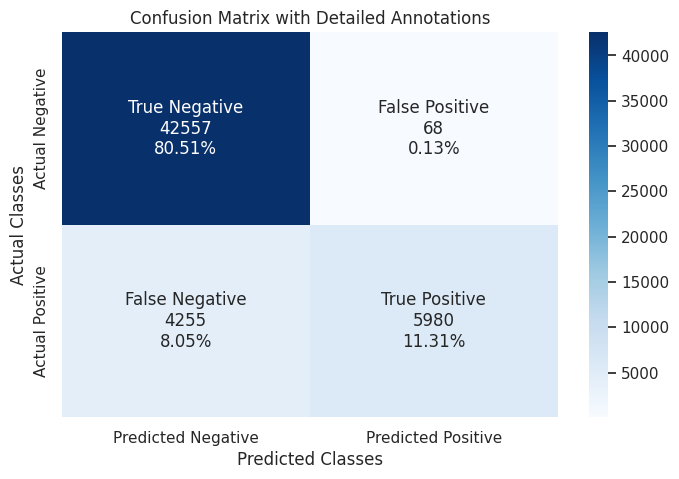

Results and evaluations saved successfully.
CPU times: user 29.9 s, sys: 7.64 s, total: 37.6 s
Wall time: 1min 5s


In [14]:
%%time
# Define filename for saving evaluation results
evaluation_results_filename = 'LR/LR_eval.txt'

# Load the model from the absolute path
model_path = os.path.join(abs_model_dir, 'logistic_regression_model.pkl')
model = load(model_path)

def main(datasets):
    env = simpy.Environment()
    normal_logger, alert_logger = setup_logging(env, 'LR/LR_normal.csv', 'LR/LR_alert.csv')

    controller = run_simulation(env, datasets, normal_logger, alert_logger)
    evaluate_and_save_results(controller)

if __name__ == "__main__":
    main(datasets)

## Naive Bayes Model Simulation

The Naive Bayes Model is run within the simulated network with the model results saved to the folder [NB Models](../simulation/results/NB). The logs are saved in the [Simulation Logs](../simulation/logs/NB) folder. With the results visualised in the simulation.

Simulation starting...
Simulation complete.
Evaluating model performance...
Baseband_1 - Accuracy: 0.86
Confusion Matrix:
[[8150 1175]
 [ 319  928]]
Classification Report:
              precision    recall  f1-score   support

         Ham       0.96      0.87      0.92      9325
        Spam       0.44      0.74      0.55      1247

    accuracy                           0.86     10572
   macro avg       0.70      0.81      0.74     10572
weighted avg       0.90      0.86      0.87     10572


Baseband_2 - Accuracy: 0.81
Confusion Matrix:
[[6865  960]
 [1079 1668]]
Classification Report:
              precision    recall  f1-score   support

         Ham       0.86      0.88      0.87      7825
        Spam       0.63      0.61      0.62      2747

    accuracy                           0.81     10572
   macro avg       0.75      0.74      0.75     10572
weighted avg       0.80      0.81      0.81     10572


Baseband_3 - Accuracy: 0.84
Confusion Matrix:
[[7683 1142]
 [ 563 1184]]
Cla

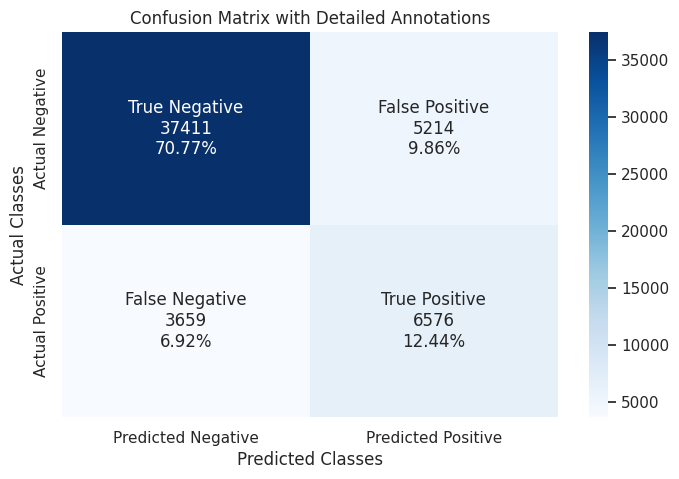

Results and evaluations saved successfully.
CPU times: user 36.6 s, sys: 9.24 s, total: 45.9 s
Wall time: 1min 20s


In [15]:
%%time
# Define filename for saving evaluation results
evaluation_results_filename = 'NB/NB_eval.txt'

# Load the model from the absolute path
model_path = os.path.join(abs_model_dir, 'naive_bayes_model.pkl')
model = load(model_path)

def main(datasets):
    env = simpy.Environment()
    normal_logger, alert_logger = setup_logging(env, 'NB/NB_normal.csv', 'NB/NB_alert.csv')

    controller = run_simulation(env, datasets, normal_logger, alert_logger)
    evaluate_and_save_results(controller)

if __name__ == "__main__":
    main(datasets)

## Random Forest Model Simulation

The Random Forest Model is run within the simulated network with the model results saved in the [RF Models](../simulation/results/RF) folder. The logs are saved in the [Simulation Logs](../simulation/logs/RF) folder. With the results visualised in the simulation.

Simulation starting...
Simulation complete.
Evaluating model performance...
Baseband_1 - Accuracy: 0.95
Confusion Matrix:
[[9320    5]
 [ 523  724]]
Classification Report:
              precision    recall  f1-score   support

         Ham       0.95      1.00      0.97      9325
        Spam       0.99      0.58      0.73      1247

    accuracy                           0.95     10572
   macro avg       0.97      0.79      0.85     10572
weighted avg       0.95      0.95      0.94     10572


Baseband_2 - Accuracy: 0.85
Confusion Matrix:
[[7821    4]
 [1618 1129]]
Classification Report:
              precision    recall  f1-score   support

         Ham       0.83      1.00      0.91      7825
        Spam       1.00      0.41      0.58      2747

    accuracy                           0.85     10572
   macro avg       0.91      0.71      0.74     10572
weighted avg       0.87      0.85      0.82     10572


Baseband_3 - Accuracy: 0.91
Confusion Matrix:
[[8820    5]
 [ 894  853]]
Cla

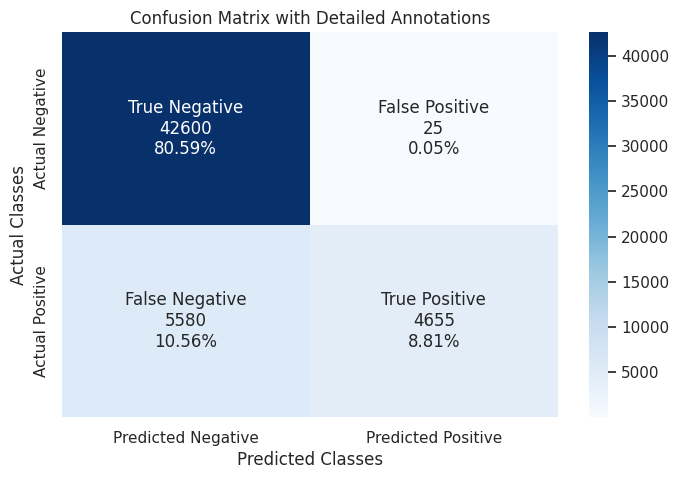

Results and evaluations saved successfully.
CPU times: user 4min 17s, sys: 9.76 s, total: 4min 27s
Wall time: 5min 9s


In [16]:
%%time
# Define filename for saving evaluation results
evaluation_results_filename = 'RF/RF_eval.txt'

# Load the model from the absolute path
model_path = os.path.join(abs_model_dir, 'random_forest_model.pkl')
model = load(model_path)

def main(datasets):
    env = simpy.Environment()
    normal_logger, alert_logger = setup_logging(env, 'RF/RF_normal.csv', 'RF/RF_alert.csv')

    controller = run_simulation(env, datasets, normal_logger, alert_logger)
    evaluate_and_save_results(controller)

if __name__ == "__main__":
    main(datasets)

## Support Vector Machine Model Simulation

The Support Vector Machine Model is run within the simulated network with the model results saved in the [SVM Models](../simulation/results/SVM) folder. The logs are saved in the [Simulation Logs](../simulation/logs/SVM) folder. With the results visualised in the simulation.

In [ ]:
%%time
# Define filename for saving evaluation results
evaluation_results_filename = 'SVM/SVM_eval.txt'

# Load the model from the absolute path
model_path = os.path.join(abs_model_dir, 'support_vector_machine_model.pkl')
model = load(model_path)

def main(datasets):
    env = simpy.Environment()
    normal_logger, alert_logger = setup_logging(env, 'SVM/SVM_normal.csv', 'SVM/SVM_alert.csv')

    controller = run_simulation(env, datasets, normal_logger, alert_logger)
    evaluate_and_save_results(controller)

if __name__ == "__main__":
    main(datasets)

Simulation starting...
